# Gamma Regression (California Housing Data)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gamma_Regression_CaliforniaHousing.ipynb)

# Imports

In [4]:
from xgboostlss.model import *
from xgboostlss.distributions.Gamma import *
from xgboostlss.distributions.LambertWGamma import *

from sklearn import datasets
from sklearn.model_selection import train_test_split
import multiprocessing
import seaborn as sns

# Data

In [5]:
n_cpu = multiprocessing.cpu_count()

housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

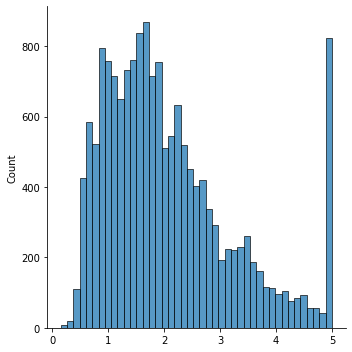

In [6]:
sns.displot(y_train)

# Distribution Selection

In [7]:
# Specifies Gamma distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gamma for an overview.
xgblss = XGBoostLSS(
     Gamma(stabilization="L2",     # Options are "None", "MAD", "L2".
          response_fn="exp",      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         )
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [8]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-12-24 18:17:50,230] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


Using 5 out of None trials for (random) startup


   0%|          | 00:00/05:00

[I 2023-12-24 18:18:01,219] Trial 0 finished with value: 3393.3214356 and parameters: {'eta': 0.0035813330843392165, 'max_depth': 5, 'gamma': 0.0020137056598854884, 'subsample': 0.6388435864809041, 'colsample_bytree': 0.5400790317373931, 'min_child_weight': 1.037623930574314e-06, 'booster': 'gbtree'}. Best is trial 0 with value: 3393.3214356.
[I 2023-12-24 18:18:16,162] Trial 1 finished with value: 4706.5838865999995 and parameters: {'eta': 1.7565757130841572e-05, 'max_depth': 8, 'gamma': 0.01842524051459991, 'subsample': 0.4905608755026831, 'colsample_bytree': 0.5772621101736957, 'min_child_weight': 9.66438820977032e-07, 'booster': 'gbtree'}. Best is trial 0 with value: 3393.3214356.


invalid value encountered in subtract


[I 2023-12-24 18:18:18,620] Trial 2 finished with value: 82663831.2 and parameters: {'eta': 0.7941443411457111, 'max_depth': 6, 'gamma': 26.988420561215726, 'subsample': 0.9048149661829232, 'colsample_bytree': 0.290940948499697, 'min_child_weight': 0.00038048363613377384, 'booster': 'gbtree'}. Best is trial 0 with value: 3393.3214356.
[I 2023-12-24 18:18:29,979] Trial 3 finished with value: 4655.022265400001 and parameters: {'eta': 0.00010287188996141415, 'max_depth': 5, 'gamma': 3.725475136661749e-05, 'subsample': 0.6891224760107537, 'colsample_bytree': 0.4935052379188369, 'min_child_weight': 67.44364439662006, 'booster': 'gbtree'}. Best is trial 0 with value: 3393.3214356.
[I 2023-12-24 18:18:39,116] Trial 4 finished with value: 4216.937109199999 and parameters: {'eta': 0.001871855810350925, 'max_depth': 1, 'gamma': 0.0002741888964798191, 'subsample': 0.8759556676557292, 'colsample_bytree': 0.8292275940944238, 'min_child_weight': 0.00035177989718919184, 'booster': 'gbtree'}. Best is 

# Model Training

In [9]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [14]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.5, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [15]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.863262,2.135935,2.724700,0.876077,2.933728,1.955459,2.739222,1.897292,2.718147,2.973438,...,2.104165,1.367046,2.733350,2.032471,1.330758,1.296328,2.216143,1.726462,2.020334,1.518069
1,1.003185,0.331126,2.064180,1.105162,1.270638,0.805180,0.410441,1.541107,1.078047,0.718936,...,0.603375,1.159040,0.867446,1.097562,0.699955,0.704483,0.750018,1.145967,1.322503,1.298179
2,1.085330,2.707571,0.934453,1.240778,1.854415,1.379302,1.983608,1.235865,1.275656,0.816549,...,1.875542,2.448452,1.655180,2.070561,1.137618,1.209052,1.784228,1.144561,1.642406,1.779368
3,2.037449,3.457704,2.137316,3.728154,2.978303,1.880429,1.455799,1.288142,2.197992,1.249174,...,1.410438,1.754009,1.927863,1.136471,2.032858,1.568591,1.463449,1.977867,2.942988,1.945552
4,3.880888,3.130139,3.671759,4.095069,2.743301,3.114958,3.058612,2.597450,5.748228,4.749651,...,3.074184,3.487740,2.940492,4.525356,3.239103,3.563927,2.048254,3.610795,4.268476,5.309752


In [16]:
pred_quantiles.head()

,quant_0.05,quant_0.5,quant_0.95
0,1.136671,1.897685,3.098423
1,0.526498,0.972055,1.576795
2,0.941861,1.520565,2.289524
3,1.150684,1.913179,2.978900
4,2.128618,3.568727,5.363509


In [17]:
pred_params.head()

,concentration,rate
0,11.565932,5.830176
1,10.350675,10.370112
2,13.677352,8.690327
3,12.708908,6.442594
4,13.439976,3.688483


In [18]:
xgblss.dist.get_params_df_loss(pred_params[["concentration", "rate"]], 
                               pd.Series(y_test).to_frame())

tensor(2709.6235)

In [19]:
pred_params["mean"] = pred_params["concentration"] / pred_params["rate"]
pred_params["var"] = pred_params["mean"] / pred_params["rate"]

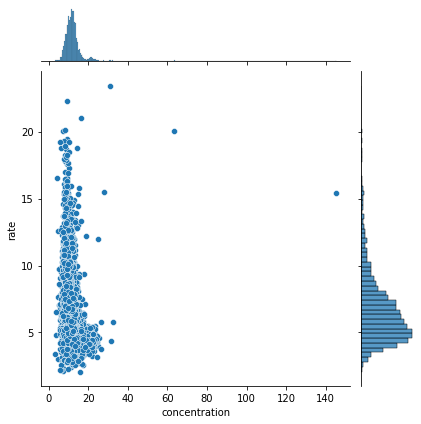

In [20]:
sns.jointplot(data=pred_params, x="concentration", y="rate")

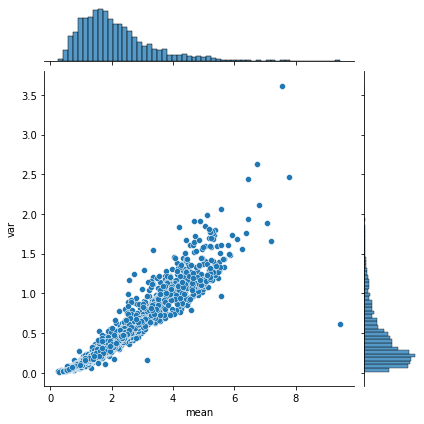

In [21]:
sns.jointplot(data=pred_params, x="mean", y="var")

# SHAP Interpretability

In [22]:
# Partial Dependence Plot
pdp_df = pd.DataFrame(X_train, columns=feature_names)

[18:23:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


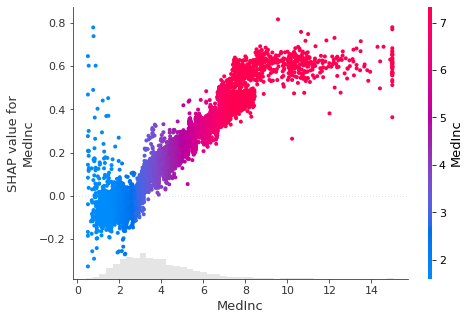

[18:23:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


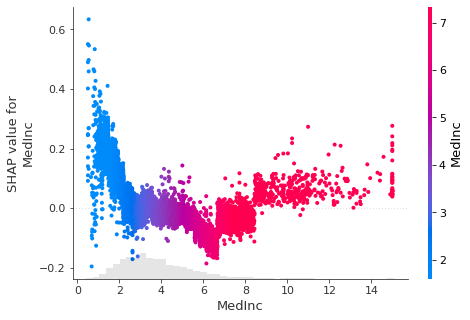

In [23]:

xgblss.plot(pdp_df,
            parameter="concentration",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

xgblss.plot(pdp_df,
            parameter="rate",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

[18:23:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


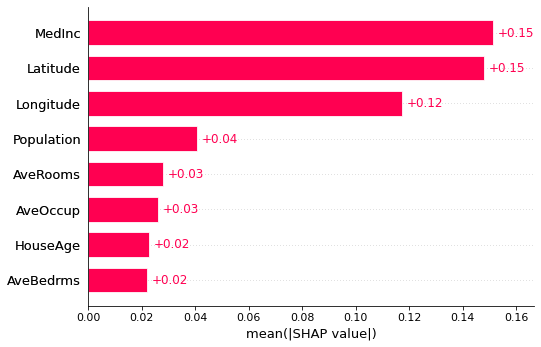

In [24]:
# Feature Importance
xgblss.plot(pdp_df,
            parameter="concentration",
            plot_type="Feature_Importance")